# Imports and params

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LEN = 30
BATCH_SIZE = 64
EPOCHS = 500
LR = 1e-3
REWARD_SCALE = 0.07


# DATASET - 1 APPLE STOCKS

In [14]:
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.X, self.y = [], []
        for i in range(len(data) - seq_len):
            self.X.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len, 3])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMPolicy(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.fc(h[:, -1])
        return out.squeeze()

class Discriminator(nn.Module):
    def __init__(self, input_size=4, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size + 1, 1)

    def forward(self, x_seq, y_pred):
        h, _ = self.lstm(x_seq)
        h_last = h[:, -1, :]
        y_pred = y_pred.unsqueeze(1)
        concat = torch.cat([h_last, y_pred], dim=1)
        return torch.sigmoid(self.fc(concat))


df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
df.dropna(inplace=True)

# df = yf.download("GOOGL", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
# df.dropna(inplace=True)
# df = yf.download("AMZN", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
# df.dropna(inplace=True)
print(df.head())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQ_LEN:]  # Include overlap for sequences

train_dataset = StockDataset(train_data, SEQ_LEN)
test_dataset = StockDataset(test_data, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

[*********************100%***********************]  1 of 1 completed

Price            Open       High        Low      Close
Ticker           AAPL       AAPL       AAPL       AAPL
Date                                                  
2015-01-02  24.778673  24.789796  23.879976  24.320427
2015-01-05  24.089084  24.169166  23.448429  23.635286
2015-01-06  23.699794  23.897774  23.274914  23.637508
2015-01-07  23.846614  24.069063  23.735389  23.968962
2015-01-08  24.298190  24.947743  24.180291  24.889906


In [ ]:
#lstm
import torch
import torch.nn as nn
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

y_true_inv=[]
y_pred_inv=[]
# Load and preprocess data
df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)

SEQ_LEN = 30
X, y = [], []
for i in range(SEQ_LEN, len(data)):
    X.append(data[i-SEQ_LEN:i])
    y.append(data[i, 3])  # Close

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = LSTM().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train
EPOCHS = 500
for epoch in range(EPOCHS):
    model.train()
    y_pred = model(X_train.cuda())
    loss = loss_fn(y_pred, y_train.cuda())
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test.cuda()).cpu().numpy()
    y_true = y_test.numpy()

# Inverse transform
min_close, max_close = scaler.data_min_[3], scaler.data_max_[3]
y_true_inv = y_true * (max_close - min_close) + min_close
y_pred_inv = y_pred * (max_close - min_close) + min_close

lstm_mse = mean_squared_error(y_true_inv, y_pred_inv)
lstm_mae = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"\n🔹 LSTM MSE: {lstm_mse:.2f}")
print(f"🔸 LSTM MAE: {lstm_mae:.2f}")
lstm=[]
lstm.append([lstm_mse,lstm_mae])


[*********************100%***********************]  1 of 1 completed


Epoch 1, Loss: 0.1198
Epoch 101, Loss: 0.0003
Epoch 201, Loss: 0.0002
Epoch 301, Loss: 0.0002
Epoch 401, Loss: 0.0002
Epoch 500, Loss: 0.0002

🔹 LSTM MSE: 22.17
🔸 LSTM MAE: 3.91


Epoch 1/500 - Loss: 0.6176
Epoch 51/500 - Loss: -0.9757
Epoch 101/500 - Loss: -0.9771
Epoch 151/500 - Loss: -0.9777
Epoch 201/500 - Loss: -0.9777
Epoch 251/500 - Loss: -0.9779
Epoch 301/500 - Loss: -0.9779
Epoch 351/500 - Loss: -0.9780
Epoch 401/500 - Loss: -0.9781
Epoch 451/500 - Loss: -0.9780
Epoch 500/500 - Loss: -0.9782


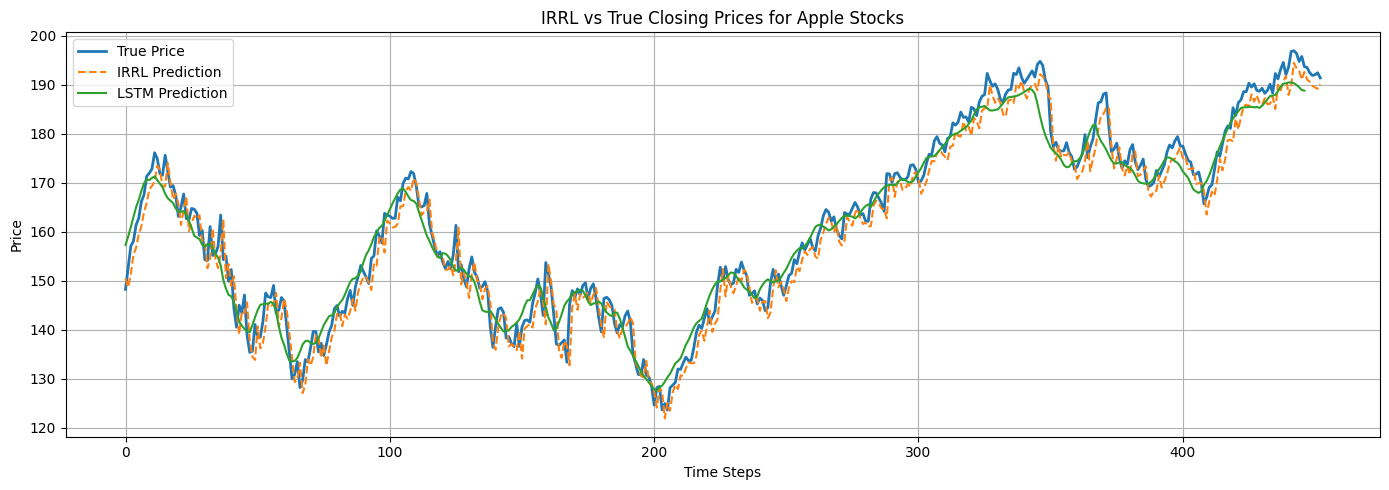

MSE: 11.46 | MAE: 2.76
445 | True: 195.76 | Pred: 191.02
446 | True: 193.67 | Pred: 192.59
447 | True: 193.52 | Pred: 191.05
448 | True: 192.44 | Pred: 190.57
449 | True: 191.90 | Pred: 189.77


In [16]:
#IRRL
policy = LSTMPolicy().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

policy_optim = optim.Adam(policy.parameters(), lr=LR)
disc_optim = optim.Adam(discriminator.parameters(), lr=LR)
mse_loss = nn.MSELoss()
reward_arr=[]

for epoch in range(EPOCHS):
    policy.train()
    discriminator.train()
    total_loss = 0

    for x_seq, y_true in train_loader:
        x_seq, y_true = x_seq.to(DEVICE), y_true.to(DEVICE)


        disc_optim.zero_grad()
        with torch.no_grad():
            y_pred = policy(x_seq)

        real_out = discriminator(x_seq, y_true)
        fake_out = discriminator(x_seq, y_pred)

        real_loss = mse_loss(real_out, torch.ones_like(real_out))
        fake_loss = mse_loss(fake_out, torch.zeros_like(fake_out))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        disc_optim.step()


        policy_optim.zero_grad()
        y_pred = policy(x_seq)
        fake_out = discriminator(x_seq, y_pred)

        reward = torch.clamp(fake_out, 0.0, 1.0) * REWARD_SCALE
        avg_reward = reward.mean().item()
        reward_arr.append(avg_reward)

        loss = mse_loss(y_pred, y_true) - reward.mean()
        loss.backward()
        policy_optim.step()

        total_loss += loss.item()

    if epoch % 50 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")
irrl=[]
true_vals, pred_vals = [], []
def evaluate_model(policy, test_loader, scaler, device):
    policy.eval()


    with torch.no_grad():
        for x_seq, y_true in test_loader:
            x_seq, y_true = x_seq.to(device), y_true.to(device)
            preds = policy(x_seq)

            true_vals.extend(y_true.squeeze().tolist())
            pred_vals.extend(preds.squeeze().tolist())


            min_close = scaler.data_min_[3]
            max_close = scaler.data_max_[3]

            true_vals_inv = np.array(true_vals) * (max_close - min_close) + min_close
            pred_vals_inv = np.array(pred_vals) * (max_close - min_close) + min_close

    plt.figure(figsize=(14, 5))
    plt.plot(true_vals_inv, label='True Price', linewidth=2)
    plt.plot(pred_vals_inv, label='IRRL Prediction',linestyle='--')
    # plt.plot(preds_rescaled, label='GRU Prediction')
    plt.plot(y_pred_inv, label='LSTM Prediction')
    plt.title("IRRL vs True Closing Prices for Apple Stocks")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    irrl_mse = np.mean((true_vals_inv - pred_vals_inv) ** 2)
    irrl_mae = np.mean(np.abs(true_vals_inv - pred_vals_inv))
    irrl.append([irrl_mse,irrl_mae])
    print(f"MSE: {irrl_mse:.2f} | MAE: {irrl_mae:.2f}")
    for i in range(445,450):
      print(f"{i:2d} | True: {true_vals_inv[i]:.2f} | Pred: {pred_vals_inv[i]:.2f}")
    # plt.figure(figsize=(10, 4))
    # plt.plot(reward_arr, label='Average Reward per Batch')
    # plt.title("Reward Progression During Training")
    # plt.xlabel("Batch (across all epochs)")
    # plt.ylabel("Reward")
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

evaluate_model(policy, test_loader, scaler, DEVICE)



# DATASET - 2 AMAZON STOCKS

In [19]:
df = yf.download("AMZN", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
df.dropna(inplace=True)

print(df.head())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQ_LEN:]  # Include overlap for sequences

train_dataset = StockDataset(train_data, SEQ_LEN)
test_dataset = StockDataset(test_data, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

[*********************100%***********************]  1 of 1 completed

Price          Open     High      Low    Close
Ticker         AMZN     AMZN     AMZN     AMZN
Date                                          
2015-01-02  15.6290  15.7375  15.3480  15.4260
2015-01-05  15.3505  15.4190  15.0425  15.1095
2015-01-06  15.1120  15.1500  14.6190  14.7645
2015-01-07  14.8750  15.0640  14.7665  14.9210
2015-01-08  15.0160  15.1570  14.8055  15.0230


In [20]:
import torch
import torch.nn as nn
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
y_true_inv=[]
y_pred_inv=[]
# Load and preprocess data
df = yf.download("AMZN", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)

SEQ_LEN = 30
X, y = [], []
for i in range(SEQ_LEN, len(data)):
    X.append(data[i-SEQ_LEN:i])
    y.append(data[i, 3])  # Close

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = LSTM().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train
EPOCHS = 500
for epoch in range(EPOCHS):
    model.train()
    y_pred = model(X_train.cuda())
    loss = loss_fn(y_pred, y_train.cuda())
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test.cuda()).cpu().numpy()
    y_true = y_test.numpy()

# Inverse transform
min_close, max_close = scaler.data_min_[3], scaler.data_max_[3]
y_true_inv = y_true * (max_close - min_close) + min_close
y_pred_inv = y_pred * (max_close - min_close) + min_close

mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"\n🔹 LSTM MSE: {mse:.2f}")
print(f"🔸 LSTM MAE: {mae:.2f}")
lstm.append([mse,mae])


[*********************100%***********************]  1 of 1 completed


Epoch 1, Loss: 0.3320
Epoch 101, Loss: 0.0005
Epoch 201, Loss: 0.0003
Epoch 301, Loss: 0.0003
Epoch 401, Loss: 0.0003
Epoch 500, Loss: 0.0003

🔹 LSTM MSE: 27.36
🔸 LSTM MAE: 3.87


Epoch 1/500 - Loss: 2.5636
Epoch 51/500 - Loss: -0.9703
Epoch 101/500 - Loss: -0.9746
Epoch 151/500 - Loss: -0.9754
Epoch 201/500 - Loss: -0.9758
Epoch 251/500 - Loss: -0.9750
Epoch 301/500 - Loss: -0.9761
Epoch 351/500 - Loss: -0.9763
Epoch 401/500 - Loss: -0.9762
Epoch 451/500 - Loss: -0.9757
Epoch 500/500 - Loss: -0.9760


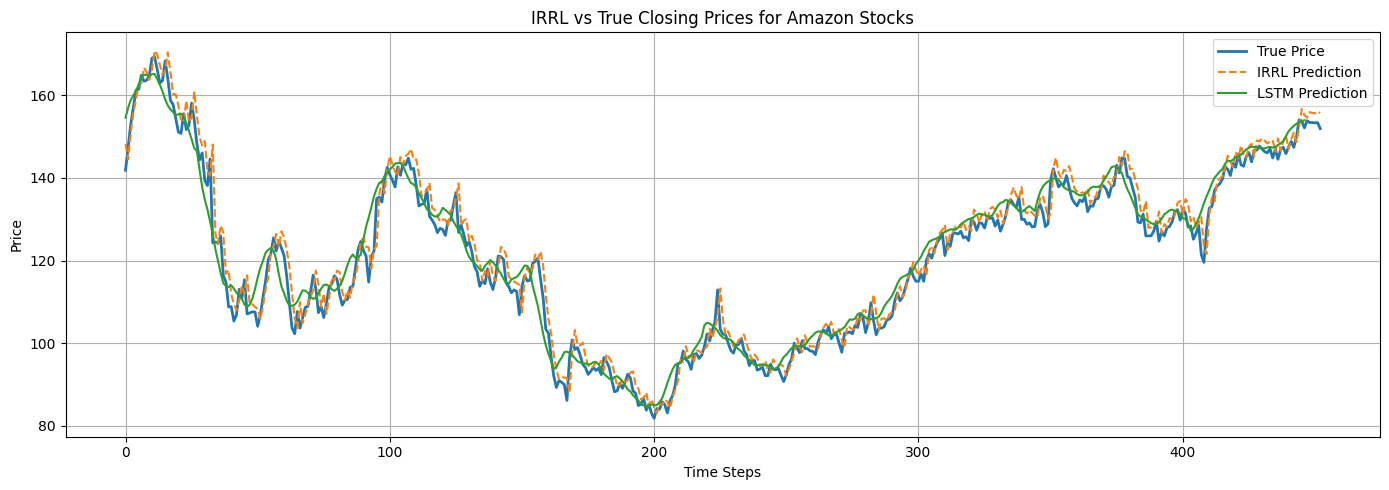


🔹 IRRL MSE: 13.39
🔸 IRRL MAE: 2.80
445 | True: 153.79 | Pred: 156.70
446 | True: 152.12 | Pred: 155.19
447 | True: 153.84 | Pred: 154.60
448 | True: 153.42 | Pred: 155.93
449 | True: 153.41 | Pred: 155.73


In [21]:

policy = LSTMPolicy().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

policy_optim = optim.Adam(policy.parameters(), lr=LR)
disc_optim = optim.Adam(discriminator.parameters(), lr=LR)
mse_loss = nn.MSELoss()
reward_arr=[]

for epoch in range(EPOCHS):
    policy.train()
    discriminator.train()
    total_loss = 0

    for x_seq, y_true in train_loader:
        x_seq, y_true = x_seq.to(DEVICE), y_true.to(DEVICE)


        disc_optim.zero_grad()
        with torch.no_grad():
            y_pred = policy(x_seq)

        real_out = discriminator(x_seq, y_true)
        fake_out = discriminator(x_seq, y_pred)

        real_loss = mse_loss(real_out, torch.ones_like(real_out))
        fake_loss = mse_loss(fake_out, torch.zeros_like(fake_out))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        disc_optim.step()


        policy_optim.zero_grad()
        y_pred = policy(x_seq)
        fake_out = discriminator(x_seq, y_pred)

        reward = torch.clamp(fake_out, 0.0, 1.0) * REWARD_SCALE
        avg_reward = reward.mean().item()
        reward_arr.append(avg_reward)
        loss = mse_loss(y_pred, y_true) - reward.mean()
        loss.backward()
        policy_optim.step()

        total_loss += loss.item()

    if epoch % 50 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")

true_vals, pred_vals = [], []
def evaluate_model(policy, test_loader, scaler, device):
    policy.eval()


    with torch.no_grad():
        for x_seq, y_true in test_loader:
            x_seq, y_true = x_seq.to(device), y_true.to(device)
            preds = policy(x_seq)

            true_vals.extend(y_true.squeeze().tolist())
            pred_vals.extend(preds.squeeze().tolist())


            min_close = scaler.data_min_[3]
            max_close = scaler.data_max_[3]

            true_vals_inv = np.array(true_vals) * (max_close - min_close) + min_close
            pred_vals_inv = np.array(pred_vals) * (max_close - min_close) + min_close

    plt.figure(figsize=(14, 5))
    plt.plot(true_vals_inv, label='True Price', linewidth=2)
    plt.plot(pred_vals_inv, label='IRRL Prediction',linestyle='--')
    plt.plot(y_pred_inv, label='LSTM Prediction')
    plt.title("IRRL vs True Closing Prices for Amazon Stocks")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    mse = np.mean((true_vals_inv - pred_vals_inv) ** 2)
    mae = np.mean(np.abs(true_vals_inv - pred_vals_inv))
    irrl.append([mse,mae])
    print(f"\n🔹 IRRL MSE: {mse:.2f}")
    print(f"🔸 IRRL MAE: {mae:.2f}")
    for i in range(445,450):
      print(f"{i:2d} | True: {true_vals_inv[i]:.2f} | Pred: {pred_vals_inv[i]:.2f}")
    # plt.figure(figsize=(10, 4))
    # plt.plot(reward_arr, label='Average Reward per Batch')
    # plt.title("Reward Progression During Training")
    # plt.xlabel("Batch (across all epochs)")
    # plt.ylabel("Reward")
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
evaluate_model(policy, test_loader, scaler, DEVICE)


In [ ]:
torch.save(policy.state_dict(), 'irrl_policy_model.pth')

# RESULTS AND TESTING

In [24]:


import pandas as pd
print("RESULTS FOR SMP")
data = {'DATASET': ['Apple', 'Amazon'],
        'LSTM MSE': [lstm[0][0],lstm[1][0]],
        'LSTM MAE': [lstm[0][1],lstm[1][1]],
        'IRRL MSE': [irrl[0][0],irrl[1][0]],
        'IRRL MAE': [irrl[0][1],irrl[1][1]]}

df = pd.DataFrame(data)
df

RESULTS FOR SMP


,DATASET,LSTM MSE,LSTM MAE,IRRL MSE,IRRL MAE
0,Apple,22.173126,3.907914,11.461338,2.761886
1,Amazon,27.361291,3.867747,13.394532,2.799257


**testing**

In [25]:

path = '/content/irrl_policy_model.pth'
policy = LSTMPolicy().to(DEVICE)
policy.load_state_dict(torch.load(path))
policy.eval()


LSTMPolicy(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

[*********************100%***********************]  1 of 1 completed


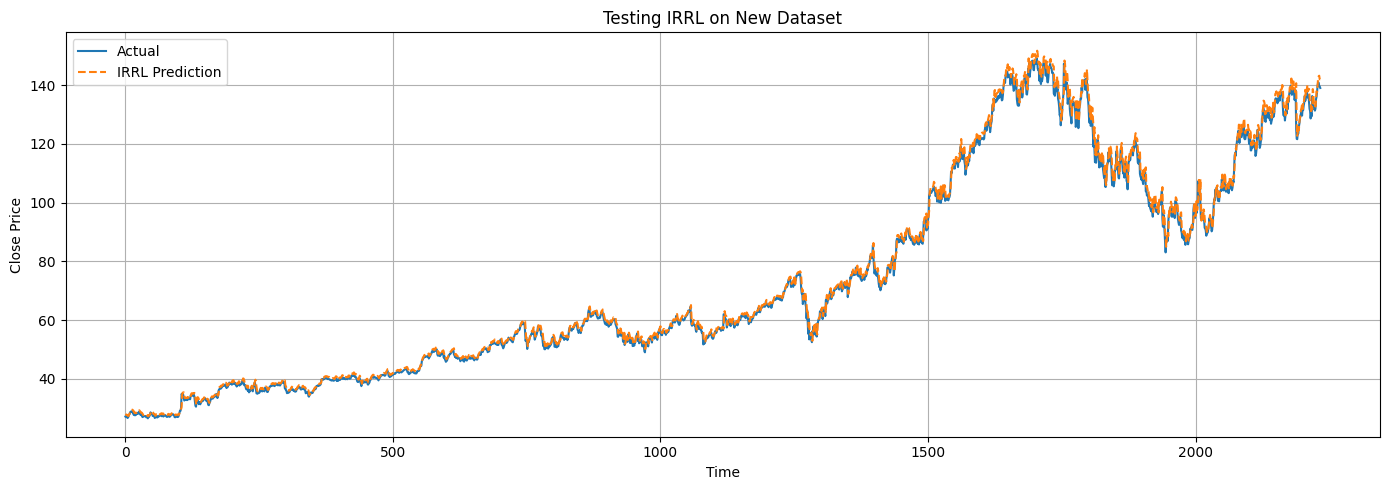

MSE: 3.78
MAE: 1.35


In [26]:
df_test = yf.download("GOOGL", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
df_test.dropna(inplace=True)
scaled_new = scaler.transform(df_test.values)
SEQ_LEN = 30
device=DEVICE
X_test_new, y_test_new = [], []
for i in range(SEQ_LEN, len(scaled_new)):
    X_test_new.append(scaled_new[i-SEQ_LEN:i])
    y_test_new.append(scaled_new[i, 3])

X_test_new = torch.tensor(np.array(X_test_new), dtype=torch.float32).to(device)
y_test_new = torch.tensor(np.array(y_test_new), dtype=torch.float32).to(device)

# 4. Use the current policy model (no need to load if trained already)
policy.eval()
with torch.no_grad():
    preds = policy(X_test_new).cpu().numpy()
    true_vals = y_test_new.cpu().numpy()

# 5. Inverse scale
min_close = scaler.data_min_[3]
max_close = scaler.data_max_[3]
preds_inv = preds * (max_close - min_close) + min_close
true_inv = true_vals * (max_close - min_close) + min_close

# 6. Plot & evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(14, 5))
plt.plot(true_inv, label="Actual")
plt.plot(preds_inv, label="IRRL Prediction", linestyle='--')
plt.title("Testing IRRL on New Dataset")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"MSE: {mean_squared_error(true_inv, preds_inv):.2f}")
print(f"MAE: {mean_absolute_error(true_inv, preds_inv):.2f}")

[*********************100%***********************]  1 of 1 completed


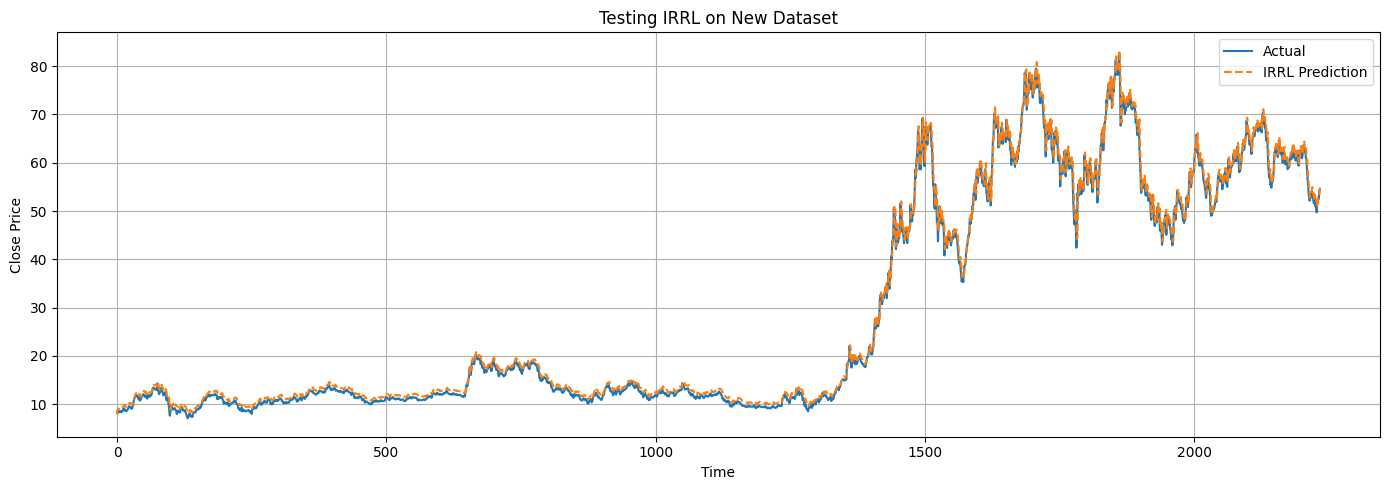

MSE: 2.02
MAE: 1.07


In [30]:
df_test = yf.download("BYDDY", start="2015-01-01", end="2023-12-31")[['Open', 'High', 'Low', 'Close']]
df_test.dropna(inplace=True)
scaled_new = scaler.transform(df_test.values)
SEQ_LEN = 30
device=DEVICE
X_test_new, y_test_new = [], []
for i in range(SEQ_LEN, len(scaled_new)):
    X_test_new.append(scaled_new[i-SEQ_LEN:i])
    y_test_new.append(scaled_new[i, 3])

X_test_new = torch.tensor(np.array(X_test_new), dtype=torch.float32).to(device)
y_test_new = torch.tensor(np.array(y_test_new), dtype=torch.float32).to(device)

# 4. Use the current policy model (no need to load if trained already)
policy.eval()
with torch.no_grad():
    preds = policy(X_test_new).cpu().numpy()
    true_vals = y_test_new.cpu().numpy()

# 5. Inverse scale
min_close = scaler.data_min_[3]
max_close = scaler.data_max_[3]
preds_inv = preds * (max_close - min_close) + min_close
true_inv = true_vals * (max_close - min_close) + min_close

# 6. Plot & evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(14, 5))
plt.plot(true_inv, label="Actual")
plt.plot(preds_inv, label="IRRL Prediction", linestyle='--')
plt.title("Testing IRRL on New Dataset")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"MSE: {mean_squared_error(true_inv, preds_inv):.2f}")
print(f"MAE: {mean_absolute_error(true_inv, preds_inv):.2f}")